In [1]:
import numpy as np

import requests
import json

from difflib import SequenceMatcher
import re

from tqdm import tqdm

import sys
print(sys.executable)

/home/jupyter-simon_horvat/.conda/envs/simon_env/bin/python


In [2]:
import numpy
import matplotlib
from transformers import AutoTokenizer

print("Numpy version:", numpy.__version__)
print("Matplotlib version:", matplotlib.__version__)

Numpy version: 1.23.5
Matplotlib version: 3.9.3


In [3]:
import tensorflow as tf
print(tf.__version__)  # Check TensorFlow version

2024-12-19 09:03:03.767136: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 09:03:03.767180: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 09:03:03.767187: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 09:03:03.772581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [4]:
# Choose a Pre-trained Model

from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# model_name = "deepset/roberta-base-squad2"
# model_name = "deepset/tinyroberta-squad2"
model_name = "distilbert-base-uncased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

In [5]:
with open("synthetic_data_200_SQuAD_placeholders_replaced_only_string.json", 'r') as file:
    data = json.load(file)

In [6]:
# Overenie ci mame len otazky typu string

"""Counts the occurrences of each answer type in the dataset."""
type_counts = {"string": 0, "number": 0, "boolean": 0}

for item in data['data']:
    for paragraph in item['paragraphs']:
        for question in paragraph['qas']:
            for answer in question['answers']:
                answer_type = answer.get('answer_type')
                if answer_type in type_counts:
                    type_counts[answer_type] += 1

f'Answer Type Statistics: {type_counts}'

"Answer Type Statistics: {'string': 2156, 'number': 0, 'boolean': 0}"

In [7]:
# Load data

from datasets import Dataset
dataset = Dataset.from_dict(data)

# Split to train test

dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset['train']
eval_dataset = dataset['test']

# Tokenizacia experimentovanie

In [8]:
# # Experimentalna tokenizacia pomocou sliding window - aktualne

# # Load data

# from datasets import Dataset
# dataset = Dataset.from_dict(data)

# # Split to train test

# dataset = dataset.train_test_split(test_size=0.2)
# train_dataset = dataset['train']
# eval_dataset = dataset['test']

# def preprocess_function(examples):
#     contexts = []
#     questions = []
#     answers = []
#     original_contexts = []
    
#     window_size = 512
#     stride = 256
    
#     for order in examples['data'][:10]:
#         for paragraph in order['paragraphs']:
#             context = paragraph["context"]
#             for i, qa in enumerate(paragraph["qas"]):
#                 question = qa["question"]
#                 answer = qa["answers"][0]
                
#                 # Create sliding windows for the context
#                 context_tokens = tokenizer(context, add_special_tokens=False)["input_ids"]
#                 if i == 0:
#                     print(len(context_tokens))
#                 for i in range(0, len(context_tokens), stride):
#                     window = context_tokens[i:i+window_size]
# #                     print(len(window))
#                     if len(window) < window_size:
#                         window += [tokenizer.pad_token_id] * (window_size - len(window))
                        
#                     # Convert token IDs back to string
#                     window_text = tokenizer.decode(window, skip_special_tokens=True)
                        
                        
#                     contexts.append(window_text)
#                     questions.append(question)
#                     answers.append(answer)
#                     original_contexts.append(context)
                
                
                    
#     inputs = tokenizer(questions, contexts, truncation=True, padding="max_length", max_length=window_size, return_offsets_mapping=True)
    
#     start_positions = []
#     end_positions = []
    
#     for i, offset_mapping in enumerate(inputs["offset_mapping"]):
#         answer = answers[i]
#         start_char = answer["answer_start"]
#         end_char = start_char + len(answer["text"])
        
#         sequence_ids = inputs.sequence_ids(i)
        
#         # Find the start and end in the context
#         context_start = sequence_ids.index(1)
#         context_end = len(sequence_ids) - 1 - sequence_ids[::-1].index(1)
        
#         # Adjust start and end positions relative to the window
#         window_start = i * stride
#         window_end = window_start + window_size
        
#         if start_char >= window_start and end_char <= window_end:
#             # Find the start and end token positions
#             start_token = context_start
#             end_token = context_end
        
#             for idx, (start, end) in enumerate(offset_mapping):
#                 if start <= start_char < end:
#                     start_token = idx
#                 if start < end_char <= end:
#                     end_token = idx
#                     break

#             start_positions.append(start_token)
#             end_positions.append(end_token)            
#         else:
#             start_positions.append(0)
#             end_positions.append(0)
            
    
#     inputs["start_positions"] = start_positions
#     inputs["end_positions"] = end_positions
    
#     return inputs

# # Apply the preprocessing function to the datasets
# train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
# eval_dataset = eval_dataset.map(preprocess_function, batched=True, remove_columns=eval_dataset.column_names)

# # Now you can use train_dataset and eval_dataset for training and evaluation

# # train_dataset['input_ids'][0]

In [9]:

# # Load data

# from datasets import Dataset
# dataset = Dataset.from_dict(data)

# # Split to train test

# dataset = dataset.train_test_split(test_size=0.2)
# train_dataset = dataset['train']
# eval_dataset = dataset['test']

# def preprocess_questions_and_context(examples, max_length=512, doc_stride=128):
#     tokenized_contexts = {}

#     # Pre-tokenize all unique contexts
#     for order in examples['data']:
#         order_id = order['title']
#         for paragraph in order['paragraphs']:
#             context = paragraph["context"]
#             if context not in tokenized_contexts:
#                 tokenized_contexts[order_id] = tokenizer(
#                     context,
#                     max_length=max_length,
#                     truncation=True,
#                     stride=doc_stride,
#                     return_overflowing_tokens=True,
#                     return_offsets_mapping=True,
#                     padding="max_length",
#                 )
            
#     print(len(tokenized_contexts.keys()))
    
#     # Prepare features for each question
#     tokenized_examples = {"input_ids": [], "attention_mask": [], "start_positions": [], "end_positions": []}
    
#     for order in examples['data']:
#         order_id = order['title']
#         paragraph = order['paragraphs'][0]
#         for qa in paragraph['qas']:
            
#             question = qa['question']
#             context = paragraph["context"]
#             answer_start = qa['answers'][0]['answer_start']
#             answer_text = qa['answers'][0]['text']

#             print(question, answer_start, answer_text)
#             print(context)
#             print("-------------------------")
#             tokenized_context = tokenized_contexts[order_id]
    
#             for i, offsets in enumerate(tokenized_context["offset_mapping"]):
#                 input_ids = tokenized_context["input_ids"][i]
#                 attention_mask = tokenized_context["attention_mask"][i]

#                 # Tokenize the question separately and combine with context
#                 tokenized_question = tokenizer(
#                     question,
#                     truncation=True,
#                     padding="max_length",
#                     max_length=max_length,
#                 )

#                 combined_input_ids = tokenized_question["input_ids"] + input_ids[1:]  # Skip context [CLS] token
#                 combined_attention_mask = tokenized_question["attention_mask"] + attention_mask[1:]

#                 token_start, token_end = None, None

#                 # Adjust answer positions
#                 if answer_start is not None and answer_text is not None:
#                     start_char = answer_start
#                     end_char = start_char + len(answer_text)

#                     context_start = len(tokenized_question["input_ids"])  # Offset for question tokens
#                     for idx, (start, end) in enumerate(offsets):
#                         if start_char >= start and start_char < end:
#                             token_start = idx + context_start
#                         if end_char > start and end_char <= end:
#                             token_end = idx + context_start
#                             break

#                 tokenized_examples["input_ids"].append(combined_input_ids[:max_length])
#                 tokenized_examples["attention_mask"].append(combined_attention_mask[:max_length])

#                 if token_start is not None and token_end is not None:
#                     tokenized_examples["start_positions"].append(token_start)
#                     tokenized_examples["end_positions"].append(token_end)
                
#     return tokenized_examples
    
# # Apply the preprocessing function to the datasets
# # tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset.column_names)
# train_dataset = train_dataset.map(preprocess_questions_and_context, batched=True, remove_columns=train_dataset.column_names)
# eval_dataset = eval_dataset.map(preprocess_questions_and_context, batched=True, remove_columns=eval_dataset.column_names)


# print(len(train_dataset))
# print(len(eval_dataset))
# # Now you can use train_dataset and eval_dataset for training and evaluation

# Len jeden kontext

In [41]:
context = data['data'][order_id]['paragraphs'][0]['context'].strip()

# print(data['data'][order_id]['paragraphs'][0]['qas'][:])
for qa in data['data'][order_id]['paragraphs'][0]['qas'][:]:
    question = qa['question']
    answer_text = qa['answers'][0]['text']
    answer_start = qa['answers'][0]['answer_start']
    answer_end = answer_start + len(answer_text)
    
    print(f"Question text: {question}")
    print(f"Answer text: {answer_text}")
    print(f"Answer context: {context[answer_start: answer_end]}")
    print(f"Answer start, end: {answer_start}, {answer_end}")
    print("-----------------------------")

Question text: Where are the goods being picked up from?
Answer text: Abbott Laboratories at Fir 145 in Tulsa, 60866, Hungary
Answer context: bott Laboratories at Fir 145 in Tulsa, 60866, Hungary b
Answer start, end: 178, 233
-----------------------------
Question text: What is the weight of the goods being transported?
Answer text: 92kg
Answer context: hem 
Answer start, end: 932, 936
-----------------------------
Question text: What type of lorry is required for the transportation?
Answer text: Small lorry
Answer context: ort these g
Answer start, end: 323, 334
-----------------------------
Question text: Where are the goods being delivered to?
Answer text: Bank of America Corp. at Plum 617 in Dallas, 03519, Fiji
Answer context:  at Plum 617 in Dallas, 03519, Fiji between 2021-03-17 1
Answer start, end: 632, 688
-----------------------------
Question text: What is the total weight of the goods being transported?
Answer text: 92kg
Answer context: hem 
Answer start, end: 932, 936
-----

In [49]:
window_size = max_length = 512
doc_stride = 256
order_id = 0

context = data['data'][order_id]['paragraphs'][0]['context']
tokenized_context = tokenizer(
                    context,
                    max_length=max_length,
                    stride=doc_stride,
                    truncation=True,
                    padding="max_length",
                    return_overflowing_tokens=True,
                    return_offsets_mapping=True,
                )
# print(len(tokenized_context['offset_mapping'][3]))
# print(tokenized_context)
# print(data['data'][order_id]['paragraphs'][0]['context'])

# print(data['data'][order_id]['paragraphs'][0]['qas'][:])
for qa in data['data'][order_id]['paragraphs'][0]['qas'][:]:
    question = qa['question']
    answer_text = qa['answers'][0]['text']
    answer_start = qa['answers'][0]['answer_start']
    answer_end = answer_start + len(answer_text)
    
    
    print(f"Answer text: {answer_text}")
    print(f"Answer context: {context[answer_start: answer_end]}")
    print(f"Answer start, end: {answer_start}, {answer_end}")
    
    # Tokenizacia otazky a kontextu - sliding windows with stride approach
    inputs = tokenizer(
        question,
        context,
        max_length=max_length,
        stride=doc_stride,
        truncation=True,
        padding="max_length",
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
    )
        
    start_positions = []
    end_positions = []
    
    for i, offset_mapping in enumerate(inputs["offset_mapping"]):
#         if i >= 1:
#             continue
            
        input_ids = inputs["input_ids"][i]
        attention_mask = inputs["attention_mask"][i]
        
#         print(offset_mapping)
        
        sequence_ids = inputs.sequence_ids(i) # Hovori nam kde sa nachadza otazka (0) a kde kontext (1)
#         print(sequence_ids)
        
        # Find the start and end in the context
        context_start = sequence_ids.index(1)
        context_end = len(sequence_ids) - 1 - sequence_ids[::-1].index(1)
        print(f"Context start, end: {context_start}, {context_end}")
        
        # Adjust start and end positions relative to the window
        window_start = offset_mapping[context_start][0]
        window_end = offset_mapping[context_end][1]
        print(f"Window start, end: {window_start}, {window_end}")
        
        # Find answer position in tokenized context
        if answer_start >= window_start and answer_end <= window_end:
            # Find the start and end token positions
            start_token = context_start
            end_token = context_end
            print(f"Start and end token (beginning): {start_token}, {end_token}")
        
            for idx, (start, end) in zip(range(start_token, end_token+1), offset_mapping[start_token: end_token+1]):
                if start <= answer_start < end:
                    start_token = idx
                if start < answer_end <= end:
                    end_token = idx
                    

            print(f"Start and end token (end): {start_token}, {end_token}")
            print(offset_mapping[start_token])
            print(offset_mapping[end_token])
            start_positions.append(start_token)
            end_positions.append(end_token) 
            
            print(f"Window {i+1}")
            
        else:
            start_positions.append(0)
            end_positions.append(0) 
        print("------------------------------")

Answer text: Wuhan Iron & Steel at Apple 1969 in Durham, 48348, Austria
Answer context: Wuhan Iron & Steel at Apple 1969 in Durham, 48348, Austria
Answer start, end: 178, 236
Context start, end: 12, 308
Window start, end: 1, 1139
Start and end token (beginning): 12, 308
Start and end token (end): 51, 66
(178, 179)
(229, 236)
Window 1
------------------------------
Answer text: 92kg
Answer context: 92kg
Answer start, end: 912, 916
Context start, end: 13, 309
Window start, end: 1, 1139
Start and end token (beginning): 13, 309
Start and end token (end): 255, 256
(912, 914)
(914, 916)
Window 1
------------------------------
Answer text: Small lorry
Answer context: Small lorry
Answer start, end: 307, 318
Context start, end: 14, 310
Window start, end: 1, 1139
Start and end token (beginning): 14, 310
Start and end token (end): 97, 99
(307, 312)
(314, 318)
Window 1
------------------------------
Answer text: Robert Half International Inc. at Cypress 1271 in Washington, 23796, Afghanistan
Answe

# Vsetky kontexty

In [20]:
# Load data

from datasets import Dataset
dataset = Dataset.from_dict(
    {
        "data": data['data'][:]
    }
)

# Split to train test

dataset = dataset.train_test_split(test_size=0.2)
train_dataset = dataset['train']
eval_dataset = dataset['test']

def preprocess_function(examples):
    
    window_size = max_length = 512
    doc_stride = 256

    contexts = []
    questions = []
    answers = []
    
    for order in examples['data'][:]:
        for paragraph in order['paragraphs']:
            context = paragraph["context"]
#             print(context)
            for question in paragraph["qas"]:
                question_text = question["question"]
                for answer in question['answers']: 
                    contexts.append(context)
                    questions.append(question_text)
                    answers.append(answer)
    
    
    # Tokenizacia otazky a kontextu - sliding windows with stride approach
    inputs = tokenizer(
        questions,
        contexts,
        max_length=max_length,
        stride=doc_stride,
        truncation=True,
        padding="max_length",
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
    )
    
    start_positions = []
    end_positions = []
    
    
    # ------------------------------
    
#     print(f"# contexts: {len(contexts)}")
#     print(f"# questions: {len(questions)}")
#     print(f"# answers: {len(answers)}")
#     print(len(inputs["offset_mapping"]))
    
    for i, offset_mapping in enumerate(inputs["offset_mapping"]):
#         print(f"Chunk {i}:")
        offset_id = inputs["overflow_to_sample_mapping"][i]
#         print(f"Offset mapping: {offset_id}")
        
        context = contexts[offset_id]
        answer = answers[offset_id]
        answer_text = answer['text']
        answer_start = answer["answer_start"]
        answer_end = answer_start + len(answer["text"])
        
#         print(f"Question: {questions[offset_id]}")
#         print(f"Answer text: {answer_text}")
#         print(f"Answer context: {context[answer_start: answer_end]}")
#         print(f"Answer start, end: {answer_start}, {answer_end}")
            
        input_ids = inputs["input_ids"][i]
        attention_mask = inputs["attention_mask"][i]
        
#         print(offset_mapping)
        
        sequence_ids = inputs.sequence_ids(i) # Hovori nam kde sa nachadza otazka (0) a kde kontext (1)
#         print(sequence_ids)
        
        # Find the start and end in the context
        context_start = sequence_ids.index(1)
        context_end = len(sequence_ids) - 1 - sequence_ids[::-1].index(1)
#         print(f"Context start, end: {context_start}, {context_end}")
        
        # Adjust start and end positions relative to the window
        window_start = offset_mapping[context_start][0]
        window_end = offset_mapping[context_end][1]
#         print(f"Window start, end: {window_start}, {window_end}")
        
        # Find answer position in tokenized context
        if answer_start >= window_start and answer_end <= window_end:
            # Find the start and end token positions
            start_token = context_start
            end_token = context_end
#             print(f"Start and end token (beginning): {start_token}, {end_token}")
        
            for idx, (start, end) in zip(range(start_token, end_token+1), offset_mapping[start_token: end_token+1]):
                if start <= answer_start < end:
                    start_token = idx
                if start < answer_end <= end:
                    end_token = idx
                    

#             print(f"Start and end token (end): {start_token}, {end_token}")
#             print(f"Offset mapping start and end token: {offset_mapping[start_token]}, {offset_mapping[end_token]}")
            start_positions.append(start_token)
            end_positions.append(end_token) 
            
#             print(f"Window {i+1}")
            
        else:
            start_positions.append(-1)
            end_positions.append(-1) 
#         print("------------------------------")
        
        
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    
#     print(inputs["start_positions"])
    
    return inputs
    
    
train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
eval_dataset = eval_dataset.map(preprocess_function, batched=True, remove_columns=eval_dataset.column_names)

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [21]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping', 'start_positions', 'end_positions'],
    num_rows: 2124
})

In [22]:
len(data['data'][0]['paragraphs'][0]['qas'])
# data['data'][0]

6

# Uz doooost

In [13]:
# Funkcna tokenizacia pre dlzky vstupov 512

def preprocess_function(examples):
    contexts = []
    questions = []
    answers = []
    
    for order in examples['data']:
        for paragraph in order['paragraphs']:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                question = qa["question"]
                answer = qa["answers"][0]
#                 print(answer)

                contexts.append(context)
                questions.append(question)
                answers.append(answer)
#                 print(answer['text'])
#                 print(f"{context[ answer['answer_start'] : answer['answer_start'] + len(answer['text']) ]}")
#                 print("--------------------------")
    
    inputs = tokenizer(questions, contexts, truncation=True, padding="max_length", max_length=512, return_offsets_mapping=True)
    
    start_positions = []
    end_positions = []
    
    for i, offset_mapping in enumerate(inputs["offset_mapping"]):
        answer = answers[i]
        start_char = answer["answer_start"]
        end_char = start_char + len(answer["text"])
        
        sequence_ids = inputs.sequence_ids(i)
#         print("------------------------------------------")
#         print(sequence_ids)
        
        # Find the start and end in the context
        context_start = sequence_ids.index(1)
        context_end = len(sequence_ids) - 1 - sequence_ids[::-1].index(1)
        
        # Find the start and end token positions
        start_token = context_start
        end_token = context_end
        
        for idx, (start, end) in enumerate(offset_mapping):
            if start <= start_char < end:
                start_token = idx
            if start < end_char <= end:
                end_token = idx
                break
        
        start_positions.append(start_token)
        end_positions.append(end_token)
    
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    
    return inputs

# Apply the preprocessing function to the datasets
# tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset.column_names)
train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
eval_dataset = eval_dataset.map(preprocess_function, batched=True, remove_columns=eval_dataset.column_names)

# Now you can use train_dataset and eval_dataset for training and evaluation

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

# Trenovanie modelu

In [23]:
# Define Training Arguments

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    logging_dir='./logs',  # Save logs here
    logging_steps=10,  # Log every 10 steps
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save model at the end of each epoch
    save_total_limit=3,  # Only keep the last 3 checkpoints
    save_steps=500,
    eval_steps=500,
    warmup_steps=500,  # number of warmup steps for learning rate scheduler
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="eval_loss",  # Use validation loss to determine the best model
    greater_is_better=False,  # Lower validation loss is better
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,  
    fp16=True,  # Use mixed precision if supported by the hardware
#     device="cuda"  # Use GPU
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [24]:
# Train the Model

from transformers import Trainer, TrainerCallback, DataCollatorWithPadding, EarlyStoppingCallback

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

/home/jupyter-simon_horvat/.conda/envs/simon_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,1.683800,1.365056
2,1.153100,0.985049
3,0.774500,0.919472
4,0.575700,0.885489
5,0.454400,0.884436
6,0.408100,0.958166
7,0.308900,0.894583
8,0.366100,0.842664
9,0.189000,0.971633
10,0.147400,1.044379


/home/jupyter-simon_horvat/.conda/envs/simon_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/jupyter-simon_horvat/.conda/envs/simon_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/jupyter-simon_horvat/.conda/envs/simon_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/jupyter-simon_horvat/.conda/envs/simon_env/lib/python3.10/

TrainOutput(global_step=670, training_loss=0.6813453900280283, metrics={'train_runtime': 169.2484, 'train_samples_per_second': 125.496, 'train_steps_per_second': 3.959, 'total_flos': 2775071844679680.0, 'train_loss': 0.6813453900280283, 'epoch': 10.0})

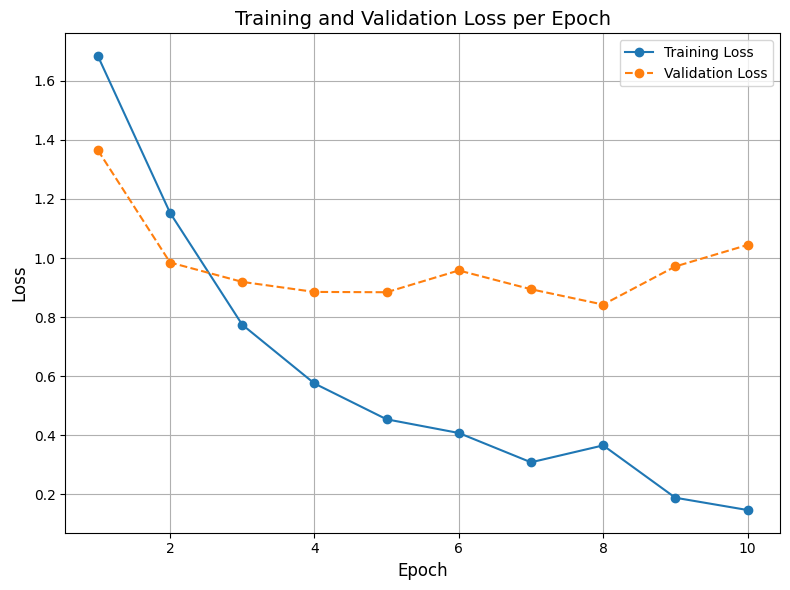

In [25]:
import matplotlib.pyplot as plt

# Data for training and validation loss
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
training_loss = [1.683800, 1.153100, 0.774500, 0.575700, 0.454400, 0.408100, 0.308900, 0.366100, 0.189000, 0.147400]
validation_loss = [1.365056, 0.985049, 0.919472, 0.885489, 0.884436, 0.958166, 0.894583, 0.842664, 0.971633, 1.044379]

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss per Epoch', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [26]:
# Evaluate the model

metrics = trainer.evaluate()
print(metrics)

/home/jupyter-simon_horvat/.conda/envs/simon_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.8426642417907715, 'eval_runtime': 1.7048, 'eval_samples_per_second': 360.748, 'eval_steps_per_second': 11.732, 'epoch': 10.0}


In [27]:
# Export the model

model.save_pretrained("./qa_model")
tokenizer.save_pretrained("./qa_model")

('./qa_model/tokenizer_config.json',
 './qa_model/special_tokens_map.json',
 './qa_model/vocab.txt',
 './qa_model/added_tokens.json',
 './qa_model/tokenizer.json')

In [28]:
# Deploy and test
from transformers import pipeline

# Load data
with open("synthetic_data_200_SQuAD_placeholders_replaced_only_string.json", 'r') as file:
    data = json.load(file)
    
# Initialize pipeline
qa_pipeline = pipeline("question-answering", model="./qa_model", tokenizer="./qa_model", device=0)

# Initialize metrics
# metric = load_metric("squad")

results = []
for i in range(10, 20):
    paragraph = data['data'][i]['paragraphs'][0]
    question = paragraph['qas'][0]
    qa_pipeline = pipeline("question-answering", model="./qa_model", tokenizer="./qa_model", device=0)
    prediction = qa_pipeline(
#         question="Where are the goods being delivered to?",
        question=question['question'],
        context=paragraph['context']
    )
    predicted_answer  = prediction['answer']
    print(prediction)
    print(f"Question: {question['question']}")
    print(f"Predicted Answer: {predicted_answer}")
    print(f"Actual answer: {question['answers'][0]['text']}")
    print("-------------------------------")

Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


{'score': 0.7266049385070801, 'start': 224, 'end': 232, 'answer': 'GasTerra'}
Question: What is the name of the company that will be picking up the goods?
Predicted Answer: GasTerra
Actual answer: GasTerra
-------------------------------
{'score': 0.58384770154953, 'start': 210, 'end': 252, 'answer': 'Mitsubishi on Fir 907 in Fort Worth, 79807'}
Question: What is the pickup location for the shipment?
Predicted Answer: Mitsubishi on Fir 907 in Fort Worth, 79807
Actual answer: Mitsubishi on Fir 907 in Fort Worth, 79807.
-------------------------------
{'score': 0.26481273770332336, 'start': 54, 'end': 58, 'answer': 'ASAP'}
Question: What kind of request is it?
Predicted Answer: ASAP
Actual answer: a hot pickup request
-------------------------------


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


{'score': 0.9853878617286682, 'start': 297, 'end': 333, 'answer': 'CHS (07646, Juniper 1159, Milwaukee)'}
Question: What is the pick-up location for the goods?
Predicted Answer: CHS (07646, Juniper 1159, Milwaukee)
Actual answer: CHS (07646, Juniper 1159, Milwaukee)
-------------------------------
{'score': 0.22568409144878387, 'start': 365, 'end': 375, 'answer': '2002-09-03'}
Question: What is the date range for the transportation order?
Predicted Answer: 2002-09-03
Actual answer: 2002-09-03
-------------------------------


Device set to use cuda:0
Device set to use cuda:0


{'score': 0.9736800789833069, 'start': 161, 'end': 177, 'answer': 'March 15th, 2030'}
Question: What is the start date of the transportation period?
Predicted Answer: March 15th, 2030
Actual answer: March 15th, 2030
-------------------------------
{'score': 0.12590137124061584, 'start': 544, 'end': 562, 'answer': 'Jersey City, 58388'}
Question: What is the city and zip code for the pickup location?
Predicted Answer: Jersey City, 58388
Actual answer: Jersey City, 58388.
-------------------------------
{'score': 0.49711546301841736, 'start': 1767, 'end': 1781, 'answer': '21512, Finland'}
Question: What is the location of the pickup?
Predicted Answer: 21512, Finland
Actual answer: W.W. Grainger Inc., located in 08354, Lebanon
-------------------------------


IndexError: list index out of range

In [29]:
eval_dataset['end_positions'][:10]

[27, 47, 113, 220, 15, 47, 113, 221, 12, 96]

# Evaluacia otazok spojenych z chunkov

In [30]:
from transformers import pipeline
from sklearn.metrics import ConfusionMatrixDisplay

# Load QA pipeline
qa_pipeline = pipeline("question-answering", model="./qa_model", tokenizer="./qa_model", device=0)

# Function to compute Exact Match (EM) score
def compute_exact_match(prediction, ground_truth):
    return int(prediction.strip().lower() == ground_truth.strip().lower())

# Function to compute F1 Score
def compute_f1(prediction, ground_truth):
    pred_tokens = prediction.strip().lower().split()
    gt_tokens = ground_truth.strip().lower().split()
    common_tokens = set(pred_tokens) & set(gt_tokens)
    if not pred_tokens or not gt_tokens:
        return 0
    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(gt_tokens)
    return (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


# Initialize lists to store metric scores
em_scores = []
f1_scores = []
precisions = []
recalls = []
CM_EM = [0,0,0,0]
CM_F1 = [0,0,0,0]
# TP, FP, FN, TN = 0, 0, 0, 0

current_predictions = []
current_ground_truth_answer = ""

# Iterate through dataset
for idx, row in tqdm(enumerate(eval_dataset), total=len(eval_dataset), desc="Evaluating"):
#     if idx >= 100:
#         break
    input_ids = row['input_ids']
    attention_mask = row['attention_mask']
    offset_mapping = row['offset_mapping']
    start_pos = row['start_positions']
    end_pos = row['end_positions']
    offset_id = eval_dataset["overflow_to_sample_mapping"][idx]
    offset_next_id = eval_dataset["overflow_to_sample_mapping"][idx+1] if idx+1 < len(eval_dataset) else -1
    
    
    # Convert input IDs to context for better interpretability (if needed)
    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=False).replace('<pad>', '')
#     print(decoded_text)
    split_text = decoded_text.split('</s>')
#     print(split_text)
    # Clean and extract the question and context
    split_text = [segment.strip('</s>').strip('<s>').strip() for segment in split_text if segment.strip()]
    
    question = split_text[0]
    context = split_text[1]
    
    # Example usage with the model
    prediction = qa_pipeline({
        "question": question,
        "context": context
    })
    
    # Process predicted span using `offset_mapping`
    predicted_start = prediction['start']
    predicted_end = prediction['end']
    predicted_answer = prediction['answer']
    
    # Spravne zistit ground truth answer - nemusi byt posledna
    # Ground truth answer from the dataset (you can adjust if you store it differently)
    ground_truth_answer = tokenizer.decode(input_ids[start_pos:end_pos+1], skip_special_tokens=True).strip()
    
    if offset_id == offset_next_id:
        current_predictions.append(prediction)
        if len(ground_truth_answer) > 0:
            current_ground_truth_answer = ground_truth_answer  
    else:
        if len(current_predictions) > 0:
            # Find the prediction with the best score
            best_prediction = max(current_predictions, key=lambda pred: pred['score'])
            predicted_answer = best_prediction['answer']
            ground_truth_answer = current_ground_truth_answer
            
            current_predictions = []
            current_ground_truth_answer = ""
            
#             print(predicted_answer)
        
#         print(f"Truth:\t\t {ground_truth_answer}")
#         print(f"Prediction:\t {predicted_answer}")
        
        # Calculate the Exact Match score
        em_score = compute_exact_match(predicted_answer, ground_truth_answer)
        em_scores.append(em_score)

         # Calculate the F1 score
        f1 = compute_f1(predicted_answer, ground_truth_answer)
        f1_scores.append(f1)

        # Precision and Recall calculations (using token-level counts)
        pred_tokens = set(predicted_answer.strip().lower().split())
        gt_tokens = set(ground_truth_answer.strip().lower().split())

        precision = len(pred_tokens & gt_tokens) / len(pred_tokens) if pred_tokens else 0
        recall = len(pred_tokens & gt_tokens) / len(gt_tokens) if gt_tokens else 0

        precisions.append(precision)
        recalls.append(recall)
        
#         if em_score == 1:
#             TP += 1
#         elif predicted_answer.strip():
#             FP += 1
#         elif ground_truth_answer.strip():
#             FN += 1

        # Matica zameny pre metriku CM
        if em_score == 1:
            CM_EM[0] += 1
        elif predicted_answer.strip():
            CM_EM[2] += 1
        elif ground_truth_answer.strip():
            CM_EM[1] += 1
            
        # Matica zameny pre metriku F1-skore
        threshold = 0.7
        if f1 >= threshold:
            CM_F1[0] += 1
        elif predicted_answer.strip():
            CM_F1[2] += 1
        elif ground_truth_answer.strip():
            CM_F1[1] += 1
        
    

#     print(f"chunk: {idx}")
#     print(f"Question: {question}")
#     print(f"Context: {context}")
#     print(f"Predicted answer:\t {predicted_answer}")
#     print(f"Actual answer:\t\t {ground_truth_answer}")
#     print(50* "-")
    
# Compute and print the overall metrics
em_score_avg = np.mean(em_scores)
f1_score_avg = np.mean(f1_scores)
precision_avg = np.mean(precisions)
recall_avg = np.mean(recalls)

print(f"Average Exact Match Score: {em_score_avg}")
print(f"Average F1 Score: {f1_score_avg}")
print(f"Average Precision: {precision_avg}")
print(f"Average Recall: {recall_avg}")

print(len(eval_dataset))
print(len(em_scores))
print(eval_dataset['overflow_to_sample_mapping'][-1])

# # Matica zameny pre metriku EM
# confusion_matrix = np.array([
#     [TP, FN],
#     [FP, TN]
# ])
# # Display confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Positive", "Negative"])
# disp.plot(cmap="Blues")
# # Add title to the confusion matrix plot
# disp.ax_.set_title("Matica zameny pre metriku EM")

# Matica zameny pre metriku EM
confusion_matrix = np.array(CM_EM).reshape(2,2)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Positive", "Negative"])
disp.plot(cmap="Blues")
# Add title to the confusion matrix plot
disp.ax_.set_title("Matica zameny pre metriku EM")

# Matica zameny pre metriku F1-skore
confusion_matrix = np.array(CM_F1).reshape(2,2)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Positive", "Negative"])
disp.plot(cmap="Blues")
# Add title to the confusion matrix plot
disp.ax_.set_title("Matica zameny pre metriku F1-skore")

# Increase font size of axis labels and ticks
disp.ax_.set_xlabel("Predicted Labels", fontsize=14)
disp.ax_.set_ylabel("True Labels", fontsize=14)
disp.ax_.tick_params(axis='both', which='major', labelsize=12)

Device set to use cuda:0
Evaluating:   0%|          | 0/615 [00:00<?, ?it/s]


IndexError: list index out of range

Device set to use cuda:0
Evaluating:   0%|          | 0/615 [00:00<?, ?it/s]/home/jupyter-simon_horvat/.conda/envs/simon_env/lib/python3.10/site-packages/transformers/pipelines/question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(
Evaluating:   2%|▏         | 14/615 [00:00<00:08, 67.51it/s]

[CLS] what kind of request is it? [SEP] pickup request at asap! goods to be transported : we ' ve got a hot pickup request here! [UNK] we need you to swing by anglo american on camellia 531 in cleveland, 16306 at your earliest convenience. [UNK] we ' re talking asap here, folks! [UNK] so, what do we have for you today? [UNK] well, we ' ve got three packages with some seriously impressive dimensions : package 1 : length - 111m, width - 36m, height - 17m, weight - 46 kg [UNK] package 2 : length - 111m, width - 36m, height - 25m, weight - 26 kg [UNK] package 3 : length - 111m, width - 36m, height - 33m, weight - 18 kg [UNK] all of these babies are stackable, so go ahead and pile ' em up! [UNK] but wait, there ' s more... we need a tail lift to securely transport these goods. no worries, though - we know you ' ve got just the vehicle for the job : a sprinter. [UNK] now, here are the juicy details : pickup time : asap [UNK] delivery time : asap [UNK] ( yep, you guessed it - we need these go

Evaluating:   3%|▎         | 21/615 [00:00<00:08, 66.82it/s]

[CLS] what is the delivery location for the goods? [SEP] sure, here ' s the natural language text based on the provided json - structured transportation order : " we have a transportation order for you! we need to pick up some goods from huawei technologies on redwood 1212 in oklahoma city, 71723 on may 11th at 1 : 15 am. the goods are a bit heavy, weighing in at 187 kg, and they ' re quite large, with dimensions of 42cm x 73cm x 65cm ( that ' s about the size of a small fridge! ). we ' ll need to use a van to transport them. oh, and we require a double driver for this job. we ' ll deliver these goods to suez environnement on apple 724 in orlando, 92588 on may 15th at 1 : 15 am. that ' s right, the same time as the pickup! the delivery address is a bit smaller than the pickup location, with dimensions of 30cm x 20cm x 72cm ( that ' s about the size of a small suitcase ). so, we ' ll need to schedule two drivers for this job. one driver will handle the pickup and delivery of the goods, 

Evaluating:   6%|▌         | 35/615 [00:00<00:09, 59.36it/s]

[CLS] what is the delivery location? [SEP] sure! here ' s the natural language text based on the transportation order : < table > < tr > < th colspan = " 2 " style = " background - color : # 009933 ; color : # ffffff ; padding : 15px ; " > transport order < / th > < / tr > < tr > < td style = " background - color : # cccccc ; padding : 15px ; " > pickup details < / td > < td style = " background - color : # cccccc ; padding : 15px ; " > < h3 > royal ahold < / h3 > < table > < tr > < th > country : < / th > < td > kuwait < / td > < / tr > < tr > < th > street name : < / th > < td > magnolia 1169 < / td > < / tr > < tr > < th > date & time : < / th > < td > asap < / td > < / tr > < / table > < / td > < / tr > < tr > < td style = " background - color : # cccccc ; padding : 15px ; " > delivery details < / td > < td style = " background - color : # cccccc ; padding : 15px ; " > < h3 > bmw < / h3 > < table > < tr > < th > country : < / th > < td > kyrgyzstan < / td > < / tr > < tr > < th > s

Evaluating:   8%|▊         | 48/615 [00:00<00:09, 57.38it/s]

[CLS] is a round trip requested? [SEP] > < li > < length > 19m < / length > < / li > < li > < width > 56m < / width > < / li > < li > < height > 64m < / height > < / li > < li > < weight > 150 kg < / weight > < / li > < / ul > < / td > < / tr > < / table > < / td > < / tr > < tr > < td style = " background - color : # cccccc ; padding : 15px ; " > required vehicle < / td > < td style = " background - color : # cccccc ; padding : 15px ; " > van < / td > < / tr > < tr > < td style = " background - color : # cccccc ; padding : 15px ; " > special ( vehicle ) request < / td > < td style = " background - color : # cccccc ; padding : 15px ; " > round trip required < / td > < / tr > < / table > note : all the details you provided are included in this text, including pickup and delivery time. i have used conversational tone to make the text stretch and added html elements for improving readability. please review and let me know if there ' s anything else i can do for you! [SEP] [PAD] [PAD] [PAD

Evaluating:  10%|█         | 62/615 [00:01<00:08, 62.84it/s]

[CLS] what is the date and time of the pickup? [SEP] / th > < td > < ul > < li > < length > 19m < / length > < / li > < li > < width > 56m < / width > < / li > < li > < height > 64m < / height > < / li > < li > < weight > 150 kg < / weight > < / li > < / ul > < / td > < / tr > < / table > < / td > < / tr > < tr > < td style = " background - color : # cccccc ; padding : 15px ; " > required vehicle < / td > < td style = " background - color : # cccccc ; padding : 15px ; " > van < / td > < / tr > < tr > < td style = " background - color : # cccccc ; padding : 15px ; " > special ( vehicle ) request < / td > < td style = " background - color : # cccccc ; padding : 15px ; " > round trip required < / td > < / tr > < / table > note : all the details you provided are included in this text, including pickup and delivery time. i have used conversational tone to make the text stretch and added html elements for improving readability. please review and let me know if there ' s anything else i can d

Evaluating:  13%|█▎        | 80/615 [00:01<00:07, 74.45it/s]

[CLS] what is the pickup location for the consignment? [SEP] pickup on april 9th between 12 : 15 p. m. and 8 : 45 p. m. : we need you to pick up a consignment of goods from company pickup on street pickup. we ' ll be delivering it on april 12th at 5 : 30 p. m. to company delivery on street delivery. the consignment consists of four 84 - meter long, 84 - meter wide, and 140 - meter high items that weigh a total of 656 kg. we need an lkw vehicle for this job since the goods are quite heavy and bulky. round trip required! please note the specific pickup and delivery times in addition to the dates. also, pay attention to the dimensions and weight of the items as they require a special vehicle for transportation. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Evaluating:  16%|█▌        | 98/615 [00:01<00:06, 78.40it/s]

[CLS] what are the dimensions of item 5? [SEP] sure! here ' s a natural language version of your transportation order : we require a sprinter vehicle for a transportation order with the following details : pickup time : asap pickup location : sistema, sequoia 1993, winston - salem, 37516, gambia delivery time : april 4, 19 : 00 : 00 ( 2034 - 04 - 04 19 : 00 : 00 ) delivery location : sheetz, azalea 1660, tulsa, 95557, haiti there are five items to be transported, with the following dimensions and weights : item 1 : length 18cm, width 47cm, height 23cm, weight 35kg item 2 : length 94cm, width 59cm, height 78cm, weight 48kg item 3 : length 36cm, width 12cm, height 83cm, weight 62kg item 4 : length 92cm, width 71cm, height 35cm, weight 19kg item 5 : length 31cm, width 25cm, height 29cm, weight 70kg please note that we require a round trip for this transportation order. please let us know if you have any questions or concerns about this order. thank you! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]

Evaluating:  19%|█▊        | 114/615 [00:01<00:06, 75.12it/s]

[CLS] what are the dimensions of the second item? [SEP] transportation order good day, esteemed crew of kohls forwarding! [UNK] i have an urgent request for a transport job that needs to be completed with utmost care and promptness. the details are as follows : pickup details : [UNK] company name : softbank country : el salvador street name : laurel 1850 datetime : between 1998 - 01 - 07 04 : 00 and 1998 - 01 - 07 13 : 15 ( please note the time ) delivery details : [UNK] company name : china faw group country : guinea street name : lilac 458 datetime : asap ( as soon as possible, please prioritize ) goods details : [UNK] weighing approximately 45 kg, the shipment consists of three items with the following dimensions and weights : [UNK] length : 84m, width : 66m, height : 30m, weight : 15 kg ( a long, rectangular box ) [UNK] length : 84m, width : 66m, height : 46m, weight : 11 kg ( a medium - sized, rectangular box ) [UNK] length : 84m, width : 66m, height : 38m, weight : 19 kg ( a larg

Evaluating:  22%|██▏       | 133/615 [00:01<00:05, 82.46it/s]

[CLS] where will the goods be delivered? [SEP] sure! here ' s a natural language version of your transportation order : " we need to transport some heavy goods from our warehouse in street pickup, zip pickup, on november 2nd at 17 : 45 to street delivery, zip delivery, on november 4th at 18 : 45. we have a big lorry with sideboards required for this job. the goods consist of four large boxes, each measuring approximately 54 meters long, 83 meters wide, and 22 meters high, weighing around 210 kilograms each. there are five boxes in total, and they need to be transported carefully and securely. please let us know if you have any questions or concerns. " i hope this version meets your needs! let me know if there ' s anything else i can help with. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Evaluating:  25%|██▍       | 151/615 [00:02<00:05, 85.52it/s]

[CLS] what is the weight of the shipment? [SEP] sure! here ' s the natural language text based on the provided json data : " we have a transportation order for you! we need to pick up a shipment of goods from lg electronics on pine 1955 in chicago, 76342, comoros between 11 : 45 and 20 : 00 on february 18th. the shipment consists of a single package with dimensions of 17cm x 60cm x 38cm and weighing 29 kg. we will need a van to transport the goods, and please note that sideboards are required. the delivery will be made to rwe on spruce 1989 in el paso, 57054, madagascar between 13 : 00 and 16 : 00 on february 19th. please let us know if you can accommodate these time slots. " i hope this meets your needs! let me know if there ' s anything else i can do for you. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Evaluating:  27%|██▋       | 169/615 [00:02<00:05, 85.85it/s]

[CLS] what is the pickup location for the shipment? [SEP] sure! here ' s the natural language text based on the transportation order you provided : " we have a shipment of goods that needs to be transported from santos in 22157, ash 1108 on thursday, june 17th between 22 : 45 and 00 : 15 to travelers cos. in 42238, rosewood 140. the shipment consists of two items with the following dimensions : * item 1 : length 37cm, width 55cm, height 64cm, weight 66kg * item 2 : length 12cm, width 55cm, height 93cm, weight 30kg we require a big lorry with double drivers to transport these goods. please note that the pickup and delivery times are thursday, june 17th between 22 : 45 and 00 : 15, and the goods have a total weight of 96kg. " i hope this text is helpful for your needs! let me know if you need any further assistance. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Evaluating:  30%|███       | 187/615 [00:02<00:04, 86.13it/s]

[CLS] what is the date and time of the delivery? [SEP] sure! here ' s the natural language text based on the provided json data : " we have a transportation order for you! we need to pick up a shipment of goods from kansai electric power located at redwood 563, colorado springs on march 11th at 5 : 30 pm. the shipment consists of three items with the following dimensions : * item 1 : length 37 meters, width 14 meters, height 32 meters, weight 34 kg * item 2 : length 28 meters, width 66 meters, height 66 meters, weight 58 kg * item 3 : length 81 meters, width 89 meters, height 62 meters, weight 92 kg we will deliver the shipment to nordea bank located at lime 337, tulsa on march 12th at 7 : 30 pm. the goods have a total weight of 184 kg and are not stackable. we will need a lkw vehicle with a tilt function ( curtain sided van ) to transport the goods safely. " i hope this text is helpful! let me know if you have any further questions or if there ' s anything else i can do for you. [SEP]

Evaluating:  33%|███▎      | 205/615 [00:02<00:05, 81.60it/s]

[CLS] what is the total weight of the shipment? [SEP] pickup transportation order : 2044 - 04 - 18, 18 : 30 : 00 we have a fantastic transportation request for you! we require your expertise to move some goods from magna international located at orange 282, 03823 on april 18th, 2044 at 18 : 30 : 00 to capital one financial corp. situated at high 262, 38894 on april 20th, 23 : 30 : 00. it ' s a thrilling journey that will take approximately two days and three hours! we ' ve got a fantastic shipment of goods for you! this bundle contains four different items, each with unique dimensions and weight specifications. you ' ll need a van to transport these goods securely, as the total weight is a whopping 284 kg! here are the measurements of each item : 1. length : 32 meters | width : 86 meters | height : 43 meters | weight : 94 kg 2. length : 62 meters | width : 62 meters | height : 83 meters | weight : 62 kg 3. length : 70 meters | width : 76 meters | height : 89 meters | weight : 68 kg 4. 

Evaluating:  35%|███▍      | 214/615 [00:02<00:05, 78.17it/s]

[CLS] what are the dimensions of package 1? [SEP] sure! here ' s the natural language text based on the transportation order you provided : " hello sunoco, i need your help with a transportation order. we have a shipment of goods that needs to be picked up from gasterra on rosewood 1616 in lexington, 60197 on october 20th at 23 : 00 : 00. the goods consist of four packages with the following dimensions : * package 1 : length 56m, width 94m, height 94m, weight 33kg * package 2 : length 42m, width 39m, height 21m, weight 60kg * package 3 : length 71m, width 76m, height 47m, weight 18kg * package 4 : length 58m, width 20m, height 10m, weight 62kg we need a small lorry for the transportation, and we require a round trip. can you please let us know if you can accommodate this request and provide us with a quote? thank you! " i hope this text meets your needs! let me know if there ' s anything else i can help with. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Evaluating:  37%|███▋      | 230/615 [00:03<00:06, 62.71it/s]

[CLS] what is the delivery time? [SEP] font - size : 18px ; " > 111 kg < / td > < / tr > < tr > < th style = " font - size : 18px ; " > dimensions < / th > < td style = " font - size : 18px ; " > < table style = " width : 100 % " > < tr > < th style = " font - size : 18px ; " > length < / th > < td style = " font - size : 18px ; " > 97m < / td > < / tr > < tr > < th style = " font - size : 18px ; " > width < / th > < td style = " font - size : 18px ; " > 95m < / td > < / tr > < tr > < th style = " font - size : 18px ; " > height < / th > < td style = " font - size : 18px ; " > 40m < / td > < / tr > < / table > < / td > < / tr > < tr > < th colspan = " 4 " style = " text - align : left ; font - size : 18px ; border - bottom : 2px solid # ccc ; " > special requests < / th > < / tr > < tr > < th style = " font - size : 18px ; " > vehicle < / th > < td style = " font - size : 18px ; " > lkw < / td > < / tr > < tr > < th style = " font - size : 18px ; " > tail lift required < / th > < td st

Evaluating:  39%|███▊      | 237/615 [00:03<00:06, 60.11it/s]

[CLS] what is the postal code for delivery? [SEP] < td style = " font - size : 18px ; " > postal code : < / td > < td style = " font - size : 18px ; " > 73576 < / td > < / tr > < tr > < th style = " font - size : 18px ; " > pickup time < / th > < td style = " font - size : 18px ; " > datetime : 2015 - 01 - 01 14 : 45 : 00 < / td > < / tr > < tr > < th style = " font - size : 18px ; " > delivery time < / th > < td style = " font - size : 18px ; " > datetime : 2015 - 01 - 04 14 : 45 : 00 < / td > < / tr > < tr > < th colspan = " 4 " style = " text - align : left ; font - size : 18px ; border - bottom : 2px solid # ccc ; " > goods details < / th > < / tr > < tr > < th style = " font - size : 18px ; " > weight < / th > < td style = " font - size : 18px ; " > 111 kg < / td > < / tr > < tr > < th style = " font - size : 18px ; " > dimensions < / th > < td style = " font - size : 18px ; " > < table style = " width : 100 % " > < tr > < th style = " font - size : 18px ; " > length < / th > < td

Evaluating:  41%|████      | 253/615 [00:03<00:05, 66.66it/s]

[CLS] what is the delivery location for the shipment? [SEP] sure! here ' s the natural language text based on the transportation order you provided : " edeka zentrale, we have a transportation order for you! on october 3rd, 2041, at 2 : 30 am, we need you to pick up some goods from bmw in norfolk, zip code 53310. the shipment consists of four packages with the following dimensions : * package 1 : length 34cm, width 31cm, height 57cm, weight 92 kg * package 2 : length 88cm, width 96cm, height 97cm, weight 70 kg * package 3 : length 77cm, width 56cm, height 83cm, weight 57 kg * package 4 : length 20cm, width 51cm, height 69cm, weight 43 kg we require a big lorry with a tail lift to transport these goods. the delivery will be made on october 7th, 2041, at 5 : 30 am, to softbank in long beach, zip code 93490. please note that the pickup and delivery times are not just on the date, but at specific times. we appreciate your prompt attention to this matter and look forward to hearing back fro

Evaluating:  44%|████▍     | 270/615 [00:03<00:05, 68.66it/s]

[CLS] what are the dimensions of the first item? [SEP] sure! here ' s the natural language transportation order based on the provided json structure : " zurich insurance group, we have a pickup request for you! we need your small lorry to collect our goods between 12 : 00 and 14 : 45 on january 24th, 2033. please note that the pickup location is at qbe insurance, with a postal code of 89221. our delivery will be made on january 29th, 2033, at 10 : 30 : 00 am. we require you to deliver the goods to bank of america, with a postal code of 85516. here ' s the detailed information about the goods we need transported : * there are two items : + the first item has dimensions of 82cm x 62cm x 16cm and weighs 63 kg. + the second item has dimensions of 29cm x 91cm x 48cm and weighs 48 kg. * both items are not stackable, so they will need to be transported separately. * we require a small lorry with a tail lift to accommodate the goods securely. please confirm receipt of this request and provide 

Evaluating:  45%|████▌     | 277/615 [00:03<00:05, 64.59it/s]

[CLS] what is the country of the pickup location? [SEP] aspen 530 < br > < strong > city : < / strong > minneapolis < br > < strong > postal code : < / strong > 98737 < br > < strong > country : < / strong > grenada < br > < strong > delivery time : < / strong > 2006 - 09 - 23 19 : 30 : 00 < / td > < / tr > < tr > < th style = " background - color : # ccccff ; padding : 10px ; " > goods details < / th > < td style = " padding : 10px ; " > < strong > weight : < / strong > 187 kg < br > < strong > dimensions : < / strong > < br > & nbsp ; & nbsp ; & nbsp ; & nbsp ; < strong > length : < / strong > 63cm, 68cm, 34cm, 60cm < br > & nbsp ; & nbsp ; & nbsp ; & nbsp ; < strong > width : < / strong > 32cm, 40cm, 37cm, 79cm < br > & nbsp ; & nbsp ; & nbsp ; & nbsp ; < strong > height : < / strong > 33cm, 85cm, 74cm, 95cm < br > < strong > special requests : < / strong > tilt required ( curtain sided van ) < / td > < / tr > < tr > < th style = " background - color : # ccccff ; padding : 10px ; " 

Evaluating:  46%|████▌     | 284/615 [00:04<00:08, 40.81it/s]

[CLS] what is the name of the company that needs to deliver the goods? [SEP] : < / strong > aspen 530 < br > < strong > city : < / strong > minneapolis < br > < strong > postal code : < / strong > 98737 < br > < strong > country : < / strong > grenada < br > < strong > delivery time : < / strong > 2006 - 09 - 23 19 : 30 : 00 < / td > < / tr > < tr > < th style = " background - color : # ccccff ; padding : 10px ; " > goods details < / th > < td style = " padding : 10px ; " > < strong > weight : < / strong > 187 kg < br > < strong > dimensions : < / strong > < br > & nbsp ; & nbsp ; & nbsp ; & nbsp ; < strong > length : < / strong > 63cm, 68cm, 34cm, 60cm < br > & nbsp ; & nbsp ; & nbsp ; & nbsp ; < strong > width : < / strong > 32cm, 40cm, 37cm, 79cm < br > & nbsp ; & nbsp ; & nbsp ; & nbsp ; < strong > height : < / strong > 33cm, 85cm, 74cm, 95cm < br > < strong > special requests : < / strong > tilt required ( curtain sided van ) < / td > < / tr > < tr > < th style = " background - co

Evaluating:  48%|████▊     | 296/615 [00:04<00:06, 46.39it/s]

[CLS] what is the country where the goods will be picked up? [SEP] / strong > aspen 530 < br > < strong > city : < / strong > minneapolis < br > < strong > postal code : < / strong > 98737 < br > < strong > country : < / strong > grenada < br > < strong > delivery time : < / strong > 2006 - 09 - 23 19 : 30 : 00 < / td > < / tr > < tr > < th style = " background - color : # ccccff ; padding : 10px ; " > goods details < / th > < td style = " padding : 10px ; " > < strong > weight : < / strong > 187 kg < br > < strong > dimensions : < / strong > < br > & nbsp ; & nbsp ; & nbsp ; & nbsp ; < strong > length : < / strong > 63cm, 68cm, 34cm, 60cm < br > & nbsp ; & nbsp ; & nbsp ; & nbsp ; < strong > width : < / strong > 32cm, 40cm, 37cm, 79cm < br > & nbsp ; & nbsp ; & nbsp ; & nbsp ; < strong > height : < / strong > 33cm, 85cm, 74cm, 95cm < br > < strong > special requests : < / strong > tilt required ( curtain sided van ) < / td > < / tr > < tr > < th style = " background - color : # ccccff

Evaluating:  50%|█████     | 308/615 [00:04<00:06, 50.26it/s]

[CLS] who is the pickup company? [SEP] sure, here ' s the natural language text for the transportation order with a conversational tone and using html elements for better readability : * * pickup details : * * * company name : aetna * pickup time : asap ( as soon as possible ) * * delivery details : * * * company name : old mutual * delivery time : march 7, 2008 at 1 : 15 am * * goods details : * * * weight : 94 kg * dimensions : + length : 98 cm + width : 94 cm + height : 19 cm + weight : 94 kg * * vehicle required : * * * small lorry * * special requests : * * * adr ( dangerous goods ) required < table > < tr > < th > pickup details < / th > < td > company name : aetna < / td > < td > pickup time : asap < / td > < / tr > < tr > < th > delivery details < / th > < td > company name : old mutual < / td > < td > delivery time : march 7, 2008 at 1 : 15 am < / td > < / tr > < tr > < th > goods details < / th > < td > weight : 94 kg < / td > < td > dimensions : < / td > < td > < table > < t

Evaluating:  52%|█████▏    | 320/615 [00:04<00:05, 52.09it/s]

[CLS] what is the company name of the delivery location? [SEP] sure, here ' s the natural language text for the transportation order with a conversational tone and using html elements for better readability : * * pickup details : * * * company name : aetna * pickup time : asap ( as soon as possible ) * * delivery details : * * * company name : old mutual * delivery time : march 7, 2008 at 1 : 15 am * * goods details : * * * weight : 94 kg * dimensions : + length : 98 cm + width : 94 cm + height : 19 cm + weight : 94 kg * * vehicle required : * * * small lorry * * special requests : * * * adr ( dangerous goods ) required < table > < tr > < th > pickup details < / th > < td > company name : aetna < / td > < td > pickup time : asap < / td > < / tr > < tr > < th > delivery details < / th > < td > company name : old mutual < / td > < td > delivery time : march 7, 2008 at 1 : 15 am < / td > < / tr > < tr > < th > goods details < / th > < td > weight : 94 kg < / td > < td > dimensions : < / t

Evaluating:  54%|█████▍    | 333/615 [00:05<00:05, 55.41it/s]

[CLS] what is the purpose of the document? [SEP] <! doctype html > < html > < head > < title > transportation order < / title > < / head > < body > < h1 > transportation order for phoenix pharmahandel < / h1 > < table > < tr > < th > pickup details : < / th > < td > < ul > < li > company name : phoenix pharmahandel < / li > < li > postal code : 71227 < / li > < li > country : congo < / li > < li > pickup time : between 1998 - 10 - 26 08 : 00 and 1998 - 10 - 26 16 : 45 < / li > < / ul > < / td > < / tr > < tr > < th > delivery details : < / th > < td > < ul > < li > company name : eli lilly < / li > < li > postal code : 39217 < / li > < li > country : iceland < / li > < li > delivery time : between 1998 - 10 - 28 21 : 15 and 1998 - 10 - 29 02 : 45 < / li > < / ul > < / td > < / tr > < / table > < br > < h2 > goods details : < / h2 > < table > < tr > < th > weight : < / th > < td > 99 kg < / td > < / tr > < tr > < th > dimensions : < / th > < td > < ul > < li > length : 92m < / li > < li

Evaluating:  56%|█████▋    | 347/615 [00:05<00:04, 59.46it/s]

[CLS] what is the postal code of the pickup location? [SEP] <! doctype html > < html > < head > < title > transportation order < / title > < / head > < body > < h1 > transportation order for phoenix pharmahandel < / h1 > < table > < tr > < th > pickup details : < / th > < td > < ul > < li > company name : phoenix pharmahandel < / li > < li > postal code : 71227 < / li > < li > country : congo < / li > < li > pickup time : between 1998 - 10 - 26 08 : 00 and 1998 - 10 - 26 16 : 45 < / li > < / ul > < / td > < / tr > < tr > < th > delivery details : < / th > < td > < ul > < li > company name : eli lilly < / li > < li > postal code : 39217 < / li > < li > country : iceland < / li > < li > delivery time : between 1998 - 10 - 28 21 : 15 and 1998 - 10 - 29 02 : 45 < / li > < / ul > < / td > < / tr > < / table > < br > < h2 > goods details : < / h2 > < table > < tr > < th > weight : < / th > < td > 99 kg < / td > < / tr > < tr > < th > dimensions : < / th > < td > < ul > < li > length : 92m < 

Evaluating:  59%|█████▉    | 362/615 [00:05<00:03, 65.65it/s]

[CLS] what is the pickup address? [SEP] sure, here ' s the natural language text based on the transportation order you provided : " we have a transportation order for you! we need you to pick up some goods from vale in seattle, 98472 between 2034 - 12 - 03 08 : 15 : 00 and 2034 - 12 - 05 07 : 30 : 00. the pickup address is apple 609, seattle. after picking up the goods, we need you to deliver them to mirvac in las vegas, 57611 between 2034 - 12 - 06 18 : 00 : 00 and 2034 - 12 - 10 03 : 30 : 00. the delivery address is fir 1715, las vegas. the goods we need you to transport are a big package that weighs 52 kg and has the following dimensions : length 93m, width 83m, height 31m. we ' ll need your big lorry to handle this job, and we request a round trip for the vehicle. please note that the pickup and delivery times are not just on the date, but also include the specific time windows. we appreciate your prompt attention to this matter! " [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

Evaluating:  61%|██████    | 376/615 [00:05<00:04, 58.78it/s]

[CLS] what are the dimensions of the goods? [SEP] sure! here ' s the natural language text from the transportation order you provided : we have a new transportation order for you! we need to pick up some goods between 1st september 2027, at 1 : 00 am, and 14th september 2027, at 2 : 00 pm, from company pickup, zip code pickup, street name pickup, city pickup. we will use a lkw vehicle to transport these goods. the goods weigh about 148 kg and have dimensions of length 39 cm, width 94 cm, and height 52 cm. the weight of each piece is as follows : 30 kg for the first item, 77 kg for the second item, and 41 kg for the third item. we will deliver these goods between 3rd september 2027 at 12 : 15 pm and 12th september 2027 at 1 : 30 pm to company delivery, zip code delivery, street name delivery, city delivery. please note that we require a round - trip for this transportation order, and please ensure that the vehicle is suitable for the job. we hope you can help us with this transportation

Evaluating:  64%|██████▍   | 394/615 [00:05<00:03, 70.63it/s]

[CLS] what is the length of item 1? [SEP] sure! here ' s the natural language text based on the transportation order you provided : " we have a transportation order for you! we need to pick up some goods from china datang in toledo, 87691 between february 18th and february 22nd, between 7 : 15 am and 10 : 45 pm. the goods include three large items with the following dimensions : * item 1 : length 46 meters, width 22 meters, height 92 meters, weight 18 kilograms * item 2 : length 68 meters, width 65 meters, height 79 meters, weight 74 kilograms * item 3 : length 37 meters, width 37 meters, height 74 meters, weight 24 kilograms we ' ll deliver these goods to repsol ypf in north las vegas, 17935 between february 24th and march 6th, between 10 : 00 pm and 8 : 30 am. please note that the goods are not stackable, and we ' ll need a small lorry with a tail lift to transport them safely. please let us know if you have any questions or concerns! we ' re looking forward to working with you. " i 

Evaluating:  67%|██████▋   | 411/615 [00:06<00:02, 69.04it/s]

[CLS] what is the delivery city? [SEP] sure, here ' s a natural language text based on your provided json - structured transportation order : - - - [UNK] transportation order : from kansai electric power to tata steel [UNK] [UNK] pickup details : [UNK] pickup company : kansai electric power [UNK] [UNK] pickup postal code : 29194 [UNK] [UNK] pickup country : ireland bekijk [UNK] pickup city : buffalo [UNK] [UNK] pickup time : between 2035 - 09 - 19 01 : 00 : 00 and 2035 - 09 - 19 10 : 15 : 00 [UNK] [UNK] delivery details : [UNK] delivery company : tata steel [UNK] [UNK] delivery postal code : 55987 [UNK] [UNK] delivery country : brazil bekijk [UNK] delivery city : dallas [UNK] [UNK] delivery time : between 2035 - 09 - 21 16 : 00 : 00 and 2035 - 10 - 02 00 : 00 : 00 [UNK] [UNK] goods details : [UNK] weight : 232 kg [UNK] [UNK] dimensions : [UNK] length : 36cm [UNK] 76cm [UNK] [UNK] width : 21cm [UNK] 96cm [UNK] [UNK] height : 10cm [UNK] 32cm [UNK] [UNK] weight : 73 kg [UNK] [UNK] require

Evaluating:  69%|██████▉   | 425/615 [00:06<00:02, 64.24it/s]

[CLS] what type of vehicle is required for the delivery? [SEP] / th > < td > < ul > < li > length : 60cm < / li > < li > width : 75cm < / li > < li > height : 10cm < / li > < li > weight : 15 kg < / li > < / ul > < / td > < / tr > < tr > < th > stackable : < / th > < td > no < / td > < / tr > < tr > < th > required vehicle : < / th > < td > small lorry < / td > < / tr > < tr > < th > special ( vehicle ) request : < / th > < td > double driver required < / td > < / tr > < / table > < br > please note that the pickup and delivery times are included in the order details. the pickup time is between 2008 - 11 - 04 14 : 30 : 00 and 2008 - 11 - 05 21 : 00 : 00, while the delivery time is between 2008 - 11 - 06 22 : 15 : 00 and 2008 - 11 - 10 19 : 45 : 00. thank you for your attention to this matter! < br > < h1 > < center > - - - end of transportation order - - - < / center > < / h1 > note : the table is not displayed as an html table, but rather as a list of properties and values. you can ad

Evaluating:  70%|███████   | 432/615 [00:06<00:02, 62.79it/s]

[CLS] is there any special request for the vehicle? [SEP] < h2 > < center > transportation order < / center > < / h2 > < table > < tr > < th > pickup details < / th > < th > delivery details < / th > < / tr > < tr > < td > company name : < / td > < td > merck < / td > < / tr > < tr > < td > street name : < / td > < td > cherry 74 < / td > < / tr > < tr > < td > city : < / td > < td > norfolk < / td > < / tr > < tr > < td > postal code : < / td > < td > 51598 < / td > < / tr > < tr > < td > country : < / td > < td > lithuania < / td > < / tr > < tr > < td > pickup time : < / td > < td > between 2008 - 11 - 04 14 : 30 : 00 and 2008 - 11 - 05 21 : 00 : 00 < / td > < / tr > < / table > < br > < h2 > < center > delivery details < / center > < / h2 > < table > < tr > < th > company name : < / th > < td > wuhan iron & steel < / td > < / tr > < tr > < td > street name : < / td > < td > broadway 1354 < / td > < / tr > < tr > < td > city : < / td > < td > fremont < / td > < / tr > < tr > < td > 

Evaluating:  73%|███████▎  | 446/615 [00:06<00:02, 59.97it/s]

[CLS] what is the special request for the vehicle? [SEP] goods details : < / th > < / tr > < tr > < td > weight : < / td > < td > 600 kg < / td > < td > dimensions : < / td > < td > < table > < tr > < td > length : < / td > < td > 240m < / td > < td > width : < / td > < td > 170m < / td > < td > height : < / td > < td > 110m < / td > < / tr > < tr > < td > weight : < / td > < td > 120 kg < / td > < / tr > < / table > < / td > < / tr > < tr > < th colspan = " 5 " > special requests : < / th > < / tr > < tr > < td > vehicle required : < / td > < td > big lorry < / td > < td > tail lift required < / td > < / tr > < / table > hi there! [UNK] we ' ve got a transportation order for you! [UNK] so, here are the details : [UNK] pickup : [UNK] * company name : vale [UNK] * country : benin [UNK] * street name : daisy 977 [UNK] * datetime : asap [UNK] delivery : [UNK] * company name : eli lilly [UNK] * country : iraq [UNK] * street name : lime 1741 [UNK] * datetime : asap [UNK] goods : [UNK] * wei

Evaluating:  75%|███████▌  | 463/615 [00:07<00:02, 70.37it/s]

[CLS] what is the pickup date and time? [SEP] sure! here ' s a natural language text version of your transportation order : " please arrange for the pickup of goods from apple, located in 36823, israel on tuesday, august 2nd between 23 : 45 and wednesday, august 3rd at 17 : 45. we require a big lorry with the ability to make a round trip for delivery to capital one financial corp. in 99854, chad between thursday, august 4th and tuesday, august 9th. the goods consist of two items with the following dimensions : * item 1 : length 52m, width 85m, height 93m, weight 45kg * item 2 : length 46m, width 10m, height 98m, weight 13kg please ensure that the vehicle is suitable for transporting these items and can accommodate their weight and dimensions. we appreciate your assistance in making this round trip possible. " i hope this meets your needs! let me know if there ' s anything else i can do to help. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

Evaluating:  78%|███████▊  | 479/615 [00:07<00:01, 71.26it/s]

[CLS] what is the weight of the first package? [SEP] pickup : attention, please! we have a hot delivery for you! [UNK] on december 9th between 12 : 30 and 14 : 30, our trusty driver will swing by tata steel on elm 465 in el paso with a postal code of 22374 to pick up your precious cargo. [UNK] delivery : hold your horses! we ' ve got another delivery for you! [UNK] on december 10th at 22 : 00 : 00, our reliable driver will arrive at bank of america on hazel 1467 in chicago with a postal code of 21503 to drop off your treasured goods. [UNK] goods : ooh la la! look what we have here! [UNK] our driver will be transporting two massive packages, each with its own unique dimensions and weight. the first package is a whopping 12 meters long, 54 meters wide, and 58 meters high, weighing in at a staggering 58 kg! [UNK] the second package is equally impressive, measuring 82 meters long, 83 meters wide, and 87 meters high, with a weight of 99 kg! [UNK] stackable : afraid not, my dear! these babie

Evaluating:  81%|████████  | 496/615 [00:07<00:01, 75.40it/s]

[CLS] what is the total weight of all three pallets? [SEP] here ' s a transportation order based on the given json data : we need your assistance with urgent transportation from visa inc. in madison as soon as possible to jx holdings in detroit. we have three large pallets of goods weighing a total of 166 kg, each measuring different dimensions, and we require a big lorry with frigo ( refrigerator truck ) for transportation. the pickup details are as follows : * company name : visa inc. * city : madison * datetime : asap ( as soon as possible ) we need you to deliver these goods at the following location and time : * company name : jx holdings * city : detroit * datetime : april 2, 2037, at 9 am. the goods are as follows : three large pallets with different dimensions and weights. the weight of each pallet is as follows : * pallet 1 weighs 66 kg, measuring 58m length, 19m width, and 79m height. * pallet 2 weighs 31 kg, measuring 71m length, 68m width, and 10m height. * pallet 3 weighs 

Evaluating:  84%|████████▎ | 514/615 [00:07<00:01, 80.25it/s]

[CLS] what is the date and time for the pickup? [SEP] sure, here ' s the natural language text based on the transportation order : " hello maruhan! we have a new transportation order for you. pickup details are as follows : * company name : insurance australia group * postal code : 97363 * street name : high 277 * date and time : july 28th, 4 : 45 pm we need you to pick up some goods for us, and here are the details : * weight : 220 kg * dimensions : + length : 19 meters + width : 40 meters + height : 80 meters + weight : 38 kg per unit + there are 5 units in total additionally, we require a van to transport these goods, and we need you to make a round trip. the delivery details are as follows : * company name : qbe insurance * postal code : 28604 * street name : lilac 1608 * date and time : july 30th, 8 : 45 pm please let us know if you can accommodate these requests. thank you! " i hope this text is helpful for your needs! let me know if there ' s anything else i can do for you. [SEP

Evaluating:  87%|████████▋ | 532/615 [00:07<00:01, 82.72it/s]

[CLS] what is the date and time of the pickup? [SEP] sure! here ' s the natural language text based on the provided json - structured transportation order : " we have a transportation order for you! [UNK] on november 5th at 7 : 30 am, we need you to pick up some goods from huawei technologies in fremont with postal code 51317. [UNK] the shipment consists of three items with the following dimensions : [UNK] length : 141m, width : 30m, height : 123m, weight : 288 kg each we need you to deliver these goods to capital one financial corp. in san antonio with postal code 91307 on november 6th at 9 : 30 am. [UNK] please note that the shipment requires a lkw vehicle, and we need you to bring a refrigerator truck ( frigo ) as it is a special request. [UNK] the total weight of the shipment is 864 kg, so make sure your vehicle can handle it! we appreciate your help in delivering these goods on time and in good condition. [UNK] " i hope this text is helpful and easy to understand! please let me kn

Evaluating:  89%|████████▉ | 550/615 [00:08<00:00, 79.10it/s]

[CLS] when is the delivery time range? [SEP] sure! here ' s a natural language text based on the provided json - structured transportation order : " we need to transport a shipment of goods from visa inc. in high 1712, 63887, gambia to nippon oil in lime 1261, 52518, cuba. the pickup will be between 2010 - 07 - 30 13 : 00 : 00 and 2010 - 07 - 31 02 : 00 : 00, and the delivery will be between 2010 - 08 - 03 06 : 15 : 00 and 2010 - 08 - 08 01 : 45 : 00. the shipment consists of three large packages with the following dimensions : * package 1 : length 10m, width 63m, height 61m, weight 12kg * package 2 : length 98m, width 58m, height 92m, weight 93kg * package 3 : length 61m, width 40m, height 63m, weight 60kg we require a lkw vehicle with a tail lift to transport these goods. please note that the shipment weighs 248 kg in total. " i hope this text is helpful for your needs! let me know if you have any further questions or requests. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

Evaluating:  91%|█████████ | 558/615 [00:08<00:00, 70.18it/s]

[CLS] what is the street name of the pickup location? [SEP] > < td style = " font - weight : bold ; " > company name : < / td > < td > china faw group < / td > < / tr > < tr > < td style = " font - weight : bold ; " > postal code : < / td > < td > 44781 < / td > < / tr > < tr > < td style = " font - weight : bold ; " > street name : < / td > < td > daisy 46 < / td > < / tr > < tr > < td style = " font - weight : bold ; " > delivery time : < / td > < td > 2032 - 07 - 19 22 : 45 : 00 < / td > < / tr > < / table > < br > < h3 align = " left " > goods details < / h3 > < table style = " width : 100 % " > < tr > < th colspan = " 2 " align = " left " > weight : < / th > < / tr > < tr > < td style = " font - weight : bold ; " > total weight : < / td > < td > 88 kg < / td > < / tr > < tr > < th colspan = " 2 " align = " left " > dimensions : < / th > < / tr > < tr > < td style = " font - weight : bold ; " > length : < / td > < td > 220 cm < / td > < / tr > < tr > < td style = " font - weight : 

Evaluating:  93%|█████████▎| 573/615 [00:08<00:00, 62.50it/s]

[CLS] what is the street name of the delivery location? [SEP] < table style = " width : 100 % " > < tr > < th colspan = " 2 " align = " left " > pickup details < / th > < / tr > < tr > < td style = " font - weight : bold ; " > company name : < / td > < td > eni < / td > < / tr > < tr > < td style = " font - weight : bold ; " > postal code : < / td > < td > 73941 < / td > < / tr > < tr > < td style = " font - weight : bold ; " > street name : < / td > < td > sycamore 1620 < / td > < / tr > < tr > < td style = " font - weight : bold ; " > pickup time : < / td > < td > 2032 - 07 - 15 22 : 45 : 00 < / td > < / tr > < / table > < br > < table style = " width : 100 % " > < tr > < th colspan = " 2 " align = " left " > delivery details < / th > < / tr > < tr > < td style = " font - weight : bold ; " > company name : < / td > < td > china faw group < / td > < / tr > < tr > < td style = " font - weight : bold ; " > postal code : < / td > < td > 44781 < / td > < / tr > < tr > < td style = " font 

Evaluating:  95%|█████████▌| 587/615 [00:08<00:00, 60.43it/s]

[CLS] what is the postal code of the pickup location? [SEP] 88 kg < / td > < / tr > < tr > < th colspan = " 2 " align = " left " > dimensions : < / th > < / tr > < tr > < td style = " font - weight : bold ; " > length : < / td > < td > 220 cm < / td > < / tr > < tr > < td style = " font - weight : bold ; " > width : < / td > < td > 145 cm < / td > < / tr > < tr > < td style = " font - weight : bold ; " > height : < / td > < td > 47 cm < / td > < / tr > < tr > < th colspan = " 2 " align = " left " > quantity : < / th > < / tr > < tr > < td style = " font - weight : bold ; " > total quantity : < / td > < td > 5 items < / td > < / tr > < / table > < br > < h3 align = " left " > special requests < / h3 > < p style = " font - style : italic ; " > double driver required for this delivery. < / p > < br > < h1 align = " left " > total weight and dimensions : < / h1 > < table style = " width : 100 % " > < tr > < th colspan = " 2 " align = " left " > total weight : < / th > < / tr > < tr > < td 

Evaluating:  98%|█████████▊| 601/615 [00:09<00:00, 60.08it/s]

[CLS] what is the postal code of the delivery location? [SEP] > < td style = " font - weight : bold ; " > company name : < / td > < td > china faw group < / td > < / tr > < tr > < td style = " font - weight : bold ; " > postal code : < / td > < td > 44781 < / td > < / tr > < tr > < td style = " font - weight : bold ; " > street name : < / td > < td > daisy 46 < / td > < / tr > < tr > < td style = " font - weight : bold ; " > delivery time : < / td > < td > 2032 - 07 - 19 22 : 45 : 00 < / td > < / tr > < / table > < br > < h3 align = " left " > goods details < / h3 > < table style = " width : 100 % " > < tr > < th colspan = " 2 " align = " left " > weight : < / th > < / tr > < tr > < td style = " font - weight : bold ; " > total weight : < / td > < td > 88 kg < / td > < / tr > < tr > < th colspan = " 2 " align = " left " > dimensions : < / th > < / tr > < tr > < td style = " font - weight : bold ; " > length : < / td > < td > 220 cm < / td > < / tr > < tr > < td style = " font - weight 

Evaluating: 100%|██████████| 615/615 [00:09<00:00, 66.75it/s]


[CLS] what is the size of each package? [SEP] pickup and delivery transportation order on april 17th, 2040, at precisely 9 : 30 a. m., our trusted driver will pick up a consignment from bertelsmann at fir 79 in hialeah, 34243, eswatini. the goods consist of four identical packages weighing 185 kg each and measuring 195 cm x 55 cm x 170 cm in size. please note that the driver will require a round trip to complete this task. the estimated delivery time is on april 20th, 2040, at 11 : 30 a. m., when he will deliver the consignment to bbva at lime 1527 in denver, 68898, cameroon. the goods are stackable and require a lkw vehicle for transportation. we kindly request that you provide a suitable vehicle for this task to ensure the safe and timely delivery of our consignment. please do not hesitate to contact us if you have any questions or concerns regarding this transportation order. our team is always ready to assist you in any way possible. thank you for your time and consideration, and w

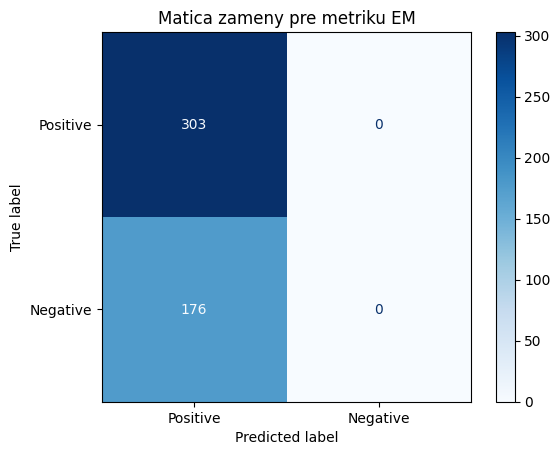

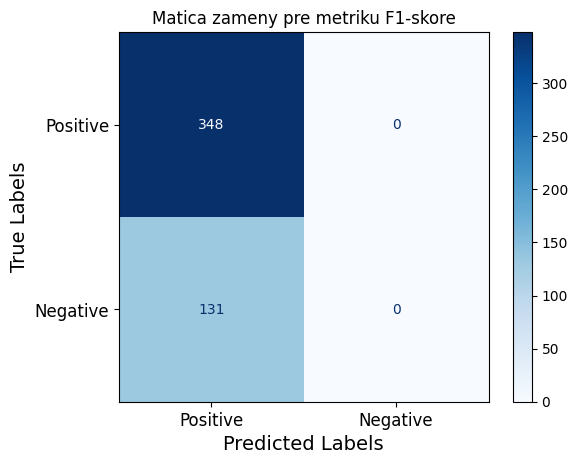

In [33]:
# Distillbert

from transformers import pipeline
from sklearn.metrics import ConfusionMatrixDisplay

# Load QA pipeline
qa_pipeline = pipeline("question-answering", model="./qa_model", tokenizer="./qa_model", device=0)

# Function to compute Exact Match (EM) score
def compute_exact_match(prediction, ground_truth):
    return int(prediction.strip().lower() == ground_truth.strip().lower())

# Function to compute F1 Score
def compute_f1(prediction, ground_truth):
    pred_tokens = prediction.strip().lower().split()
    gt_tokens = ground_truth.strip().lower().split()
    common_tokens = set(pred_tokens) & set(gt_tokens)
    if not pred_tokens or not gt_tokens:
        return 0
    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(gt_tokens)
    return (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


# Initialize lists to store metric scores
em_scores = []
f1_scores = []
precisions = []
recalls = []
CM_EM = [0,0,0,0]
CM_F1 = [0,0,0,0]
# TP, FP, FN, TN = 0, 0, 0, 0

current_predictions = []
current_ground_truth_answer = ""

# Iterate through dataset
for idx, row in tqdm(enumerate(eval_dataset), total=len(eval_dataset), desc="Evaluating"):
#     if idx >= 100:
#         break
    input_ids = row['input_ids']
    attention_mask = row['attention_mask']
    offset_mapping = row['offset_mapping']
    start_pos = row['start_positions']
    end_pos = row['end_positions']
    offset_id = eval_dataset["overflow_to_sample_mapping"][idx]
    offset_next_id = eval_dataset["overflow_to_sample_mapping"][idx+1] if idx+1 < len(eval_dataset) else -1
    
    
    # Convert input IDs to context for better interpretability (if needed)
    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=False).replace('<pad>', '')
    print(decoded_text)
    split_text = decoded_text.split('[SEP]')
    print(split_text)
    # Clean and extract the question and context
    split_text = [segment.strip('</s>').strip('<s>').strip() for segment in split_text if segment.strip()]
    
    question = split_text[0]
    context = split_text[1]
    
    # Example usage with the model
    prediction = qa_pipeline({
        "question": question,
        "context": context
    })
    
    # Process predicted span using `offset_mapping`
    predicted_start = prediction['start']
    predicted_end = prediction['end']
    predicted_answer = prediction['answer']
    
    # Spravne zistit ground truth answer - nemusi byt posledna
    # Ground truth answer from the dataset (you can adjust if you store it differently)
    ground_truth_answer = tokenizer.decode(input_ids[start_pos:end_pos+1], skip_special_tokens=True).strip()
    
    if offset_id == offset_next_id:
        current_predictions.append(prediction)
        if len(ground_truth_answer) > 0:
            current_ground_truth_answer = ground_truth_answer  
    else:
        if len(current_predictions) > 0:
            # Find the prediction with the best score
            best_prediction = max(current_predictions, key=lambda pred: pred['score'])
            predicted_answer = best_prediction['answer']
            ground_truth_answer = current_ground_truth_answer
            
            current_predictions = []
            current_ground_truth_answer = ""
            
#             print(predicted_answer)
        
#         print(f"Truth:\t\t {ground_truth_answer}")
#         print(f"Prediction:\t {predicted_answer}")
        
        # Calculate the Exact Match score
        em_score = compute_exact_match(predicted_answer, ground_truth_answer)
        em_scores.append(em_score)

         # Calculate the F1 score
        f1 = compute_f1(predicted_answer, ground_truth_answer)
        f1_scores.append(f1)

        # Precision and Recall calculations (using token-level counts)
        pred_tokens = set(predicted_answer.strip().lower().split())
        gt_tokens = set(ground_truth_answer.strip().lower().split())

        precision = len(pred_tokens & gt_tokens) / len(pred_tokens) if pred_tokens else 0
        recall = len(pred_tokens & gt_tokens) / len(gt_tokens) if gt_tokens else 0

        precisions.append(precision)
        recalls.append(recall)
        
#         if em_score == 1:
#             TP += 1
#         elif predicted_answer.strip():
#             FP += 1
#         elif ground_truth_answer.strip():
#             FN += 1

        # Matica zameny pre metriku CM
        if em_score == 1:
            CM_EM[0] += 1
        elif predicted_answer.strip():
            CM_EM[2] += 1
        elif ground_truth_answer.strip():
            CM_EM[1] += 1
            
        # Matica zameny pre metriku F1-skore
        threshold = 0.7
        if f1 >= threshold:
            CM_F1[0] += 1
        elif predicted_answer.strip():
            CM_F1[2] += 1
        elif ground_truth_answer.strip():
            CM_F1[1] += 1
        
    

#     print(f"chunk: {idx}")
#     print(f"Question: {question}")
#     print(f"Context: {context}")
#     print(f"Predicted answer:\t {predicted_answer}")
#     print(f"Actual answer:\t\t {ground_truth_answer}")
#     print(50* "-")
    
# Compute and print the overall metrics
em_score_avg = np.mean(em_scores)
f1_score_avg = np.mean(f1_scores)
precision_avg = np.mean(precisions)
recall_avg = np.mean(recalls)

print(f"Average Exact Match Score: {em_score_avg}")
print(f"Average F1 Score: {f1_score_avg}")
print(f"Average Precision: {precision_avg}")
print(f"Average Recall: {recall_avg}")

print(len(eval_dataset))
print(len(em_scores))
print(eval_dataset['overflow_to_sample_mapping'][-1])

# # Matica zameny pre metriku EM
# confusion_matrix = np.array([
#     [TP, FN],
#     [FP, TN]
# ])
# # Display confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Positive", "Negative"])
# disp.plot(cmap="Blues")
# # Add title to the confusion matrix plot
# disp.ax_.set_title("Matica zameny pre metriku EM")

# Matica zameny pre metriku EM
confusion_matrix = np.array(CM_EM).reshape(2,2)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Positive", "Negative"])
disp.plot(cmap="Blues")
# Add title to the confusion matrix plot
disp.ax_.set_title("Matica zameny pre metriku EM")

# Matica zameny pre metriku F1-skore
confusion_matrix = np.array(CM_F1).reshape(2,2)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Positive", "Negative"])
disp.plot(cmap="Blues")
# Add title to the confusion matrix plot
disp.ax_.set_title("Matica zameny pre metriku F1-skore")

# Increase font size of axis labels and ticks
disp.ax_.set_xlabel("Predicted Labels", fontsize=14)
disp.ax_.set_ylabel("True Labels", fontsize=14)
disp.ax_.tick_params(axis='both', which='major', labelsize=12)

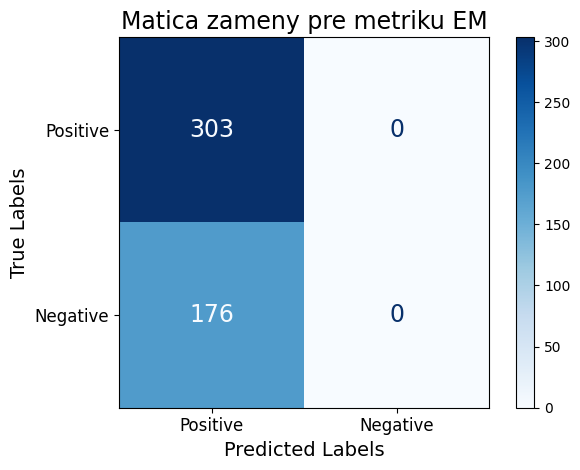

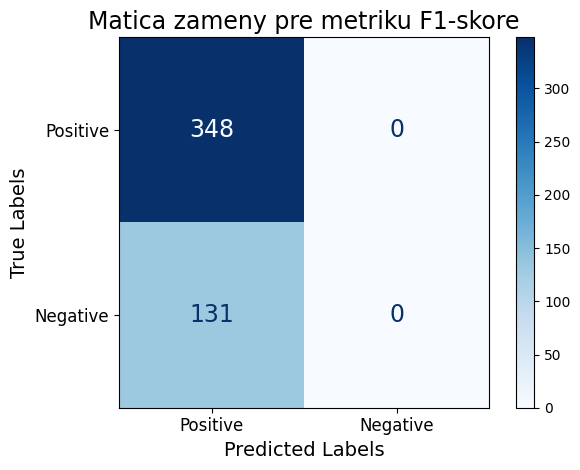

In [35]:
# Matica zameny pre metriku EM
confusion_matrix = np.array(CM_EM).reshape(2,2)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Positive", "Negative"])
disp.plot(cmap="Blues")
# Add title to the confusion matrix plot
disp.ax_.set_title("Matica zameny pre metriku EM", fontsize=17)

# Increase font size of axis labels and ticks
disp.ax_.set_xlabel("Predicted Labels", fontsize=14)
disp.ax_.set_ylabel("True Labels", fontsize=14)
disp.ax_.tick_params(axis='both', which='major', labelsize=12)

# Increase font size for text inside the matrix
for text in disp.ax_.texts:
    text.set_fontsize(17)  # Adjust the font size here
    
# Show the plot
plt.tight_layout()
plt.show()


# Matica zameny pre metriku F1-skore
confusion_matrix = np.array(CM_F1).reshape(2,2)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Positive", "Negative"])
disp.plot(cmap="Blues")
# Add title to the confusion matrix plot
disp.ax_.set_title("Matica zameny pre metriku F1-skore", fontsize=17)

# Increase font size of axis labels and ticks
disp.ax_.set_xlabel("Predicted Labels", fontsize=14)
disp.ax_.set_ylabel("True Labels", fontsize=14)
disp.ax_.tick_params(axis='both', which='major', labelsize=12)

# Increase font size for text inside the matrix
for text in disp.ax_.texts:
    text.set_fontsize(17)  # Adjust the font size here

# Show the plot
plt.tight_layout()
plt.show()

In [19]:
print(len(eval_dataset))
print(len(em_scores))
print(eval_dataset['overflow_to_sample_mapping'][-1])

1596
427
426


In [ ]:
from transformers import pipeline
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from jiwer import wer, cer
# from cer import cer
from bert_score import score

# Load QA pipeline
qa_pipeline = pipeline("question-answering", model="./qa_model", tokenizer="./qa_model", device=0)

# Function to compute Exact Match (EM) score
def compute_exact_match(prediction, ground_truth):
    return int(prediction.strip().lower() == ground_truth.strip().lower())

# Function to compute F1 Score
def compute_f1(prediction, ground_truth):
    pred_tokens = prediction.strip().lower().split()
    gt_tokens = ground_truth.strip().lower().split()
    common_tokens = set(pred_tokens) & set(gt_tokens)
    if not pred_tokens or not gt_tokens:
        return 0
    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(gt_tokens)
    return (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Function to compute Precision and Recall
def compute_precision_recall(prediction, ground_truth):
    pred_tokens = set(prediction.strip().lower().split())
    gt_tokens = set(ground_truth.strip().lower().split())

    precision = len(pred_tokens & gt_tokens) / len(pred_tokens) if pred_tokens else 0
    recall = len(pred_tokens & gt_tokens) / len(gt_tokens) if gt_tokens else 0

    return precision, recall

# Function to compute Mean Reciprocal Rank (MRR)
def compute_mrr(prediction, ground_truth, rank):
    return 1.0 / rank if prediction.strip().lower() == ground_truth.strip().lower() else 0

# Function to compute ROUGE
def compute_rouge(prediction, ground_truth):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(ground_truth, prediction)
    return scores

# Function to compute BLEU
def compute_bleu(prediction, ground_truth):
    pred_tokens = prediction.strip().lower().split()
    gt_tokens = ground_truth.strip().lower().split()
    return sentence_bleu([gt_tokens], pred_tokens)

# Function to compute Word Error Rate (WER)
def compute_wer(prediction, ground_truth):
    return jiwer.wer(ground_truth, prediction)

# Function to compute Character Error Rate (CER)
def compute_cer(prediction, ground_truth):
    return cer(prediction, ground_truth)

# Function to compute BERTScore
def compute_bertscore(prediction, ground_truth):
    P, R, F1 = score([prediction], [ground_truth], lang="en")
    return F1[0].item()

# Function to compute Token-level Accuracy
def compute_token_accuracy(prediction, ground_truth):
    pred_tokens = prediction.strip().lower().split()
    gt_tokens = ground_truth.strip().lower().split()
    correct_tokens = len(set(pred_tokens) & set(gt_tokens))
    total_tokens = len(gt_tokens)
    return correct_tokens / total_tokens if total_tokens > 0 else 0

# Initialize lists to store metric scores
em_scores = []
f1_scores = []
precisions = []
recalls = []
tp_list = []
fp_list = []
fn_list = []
mrr_scores = []
rouge_scores = []
bleu_scores = []
wer_scores = []
cer_scores = []
bertscore_scores = []
token_accuracy_scores = []

# Iterate through dataset
for idx, row in tqdm(enumerate(eval_dataset), total=len(eval_dataset), desc="Evaluating"):
    input_ids = row['input_ids']
    attention_mask = row['attention_mask']
    offset_mapping = row['offset_mapping']
    start_pos = row['start_positions']
    end_pos = row['end_positions']
    
    # Convert input IDs to context for better interpretability (if needed)
    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=False).replace('<pad>', '')
    split_text = decoded_text.split('</s>')
    
    # Clean and extract the question and context
    split_text = [segment.strip('</s>').strip('<s>').strip() for segment in split_text if segment.strip()]
    question = split_text[0]
    context = split_text[1]

    # Get the predicted answer
    prediction = qa_pipeline({
        "question": question,
        "context": context
    })
    predicted_answer = prediction['answer']
    
    # Extract ground truth answer from the dataset
    ground_truth_answer = tokenizer.decode(input_ids[start_pos:end_pos+1], skip_special_tokens=True).strip()
    
    # Calculate the Exact Match score
    em_score = compute_exact_match(predicted_answer, ground_truth_answer)
    em_scores.append(em_score)

    # Calculate the F1 score
    f1 = compute_f1(predicted_answer, ground_truth_answer)
    f1_scores.append(f1)

    # Precision and Recall calculations
    precision, recall = compute_precision_recall(predicted_answer, ground_truth_answer)
    precisions.append(precision)
    recalls.append(recall)
    
    # Calculate True Positives, False Positives, False Negatives
    tp = len(set(predicted_answer.strip().lower().split()) & set(ground_truth_answer.strip().lower().split()))
    fp = len(set(predicted_answer.strip().lower().split()) - set(ground_truth_answer.strip().lower().split()))
    fn = len(set(ground_truth_answer.strip().lower().split()) - set(predicted_answer.strip().lower().split()))
    tp_list.append(tp)
    fp_list.append(fp)
    fn_list.append(fn)
    
    # Calculate Mean Reciprocal Rank (MRR)
    mrr = compute_mrr(predicted_answer, ground_truth_answer, idx+1)
    mrr_scores.append(mrr)

    # ROUGE Scores
    rouge_score = compute_rouge(predicted_answer, ground_truth_answer)
    rouge_scores.append(rouge_score)

    # BLEU Score
    bleu_score = compute_bleu(predicted_answer, ground_truth_answer)
    bleu_scores.append(bleu_score)

    # Word Error Rate (WER)
    wer_score = compute_wer(predicted_answer, ground_truth_answer)
    wer_scores.append(wer_score)

    # Character Error Rate (CER)
    cer_score = compute_cer(predicted_answer, ground_truth_answer)
    cer_scores.append(cer_score)

    # BERTScore
    bertscore_score = compute_bertscore(predicted_answer, ground_truth_answer)
    bertscore_scores.append(bertscore_score)

    # Token-level Accuracy
    token_accuracy = compute_token_accuracy(predicted_answer, ground_truth_answer)
    token_accuracy_scores.append(token_accuracy)

# Compute and print the overall metrics
em_score_avg = np.mean(em_scores)
f1_score_avg = np.mean(f1_scores)
precision_avg = np.mean(precisions)
recall_avg = np.mean(recalls)
tp_avg = np.mean(tp_list)
fp_avg = np.mean(fp_list)
fn_avg = np.mean(fn_list)
mrr_avg = np.mean(mrr_scores)
rouge_avg = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
bleu_avg = np.mean(bleu_scores)
wer_avg = np.mean(wer_scores)
cer_avg = np.mean(cer_scores)
bertscore_avg = np.mean(bertscore_scores)
token_accuracy_avg = np.mean(token_accuracy_scores)

print(f"Average Exact Match Score: {em_score_avg}")
print(f"Average F1 Score: {f1_score_avg}")
print(f"Average Precision: {precision_avg}")
print(f"Average Recall: {recall_avg}")
print(f"Average True Positives: {tp_avg}")
print(f"Average False Positives: {fp_avg}")
print(f"Average False Negatives: {fn_avg}")
print(f"Average Mean Reciprocal Rank: {mrr_avg}")
print(f"Average ROUGE Score: {rouge_avg}")
print(f"Average BLEU Score: {bleu_avg}")
print(f"Average Word Error Rate (WER): {wer_avg}")
print(f"Average Character Error Rate (CER): {cer_avg}")
print(f"Average BERTScore: {bertscore_avg}")
print(f"Average Token-level Accuracy: {token_accuracy_avg}")